# Setup

In [1]:
# Import python packages
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import math
from datetime import datetime as dt

# # Cartopy imports
import cartopy.crs as ccrs
from cartopy import util as cutil

from matplotlib import animation
from matplotlib.widgets import Button, Slider
import warnings

plt.close('all')

In [2]:
# Loading in dataset:
# to open dataset where files are located, enter path and name of file (use 'copy path' in file manager)
# if doing so, slashes will be wrong, so change \ to '/' or '\\'
# to open multiple versions/variables, either use * in place of characters in file name string or list multiple files using ['filepath1', filepath2', etc]


file = 'H:\\Summer24-25\\*_Amon_CESM2-WACCM_ssp126*.nc' # enter file path here --> use * if need multiple files/versions per dataset
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # some datasets have empty values, this ignores that warning--> if gives error, remove this to check
    ds = xr.open_mfdataset(file)

# this bit is to change the units of 'plev' (pressure level Pa -> hPa)
if ds.plev.attrs['units'] == 'Pa':
    ds['plev'] = ds.plev / 100
    ds.plev.attrs['axis'] = 'Z' # attributes get reset so have to redo them
    ds.plev.attrs['positive'] = 'down'
    ds.plev.attrs['standard_name'] = 'air_pressure'
    ds.plev.attrs['title'] = 'pressure'
    ds.plev.attrs['type'] = 'double'
    ds.plev.attrs['units'] = 'hPa'

ds.plev

<xarray.DataArray 'plev' (plev: 19)> Size: 152B
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.,    5.,    1.])
Coordinates:
  * plev     (plev) float64 152B 1e+03 925.0 850.0 700.0 ... 20.0 10.0 5.0 1.0
Attributes:
    axis:           Z
    positive:       down
    standard_name:  air_pressure
    title:          pressure
    type:           double
    units:          hPa

In [18]:
def timefmt(timeindex, format='%Y %B'):
    date = dt.strptime(str(ds.time[timeindex].values), '%Y-%m-%d %H:%M:%S')
    return date.strftime(format)

# Selecting data:

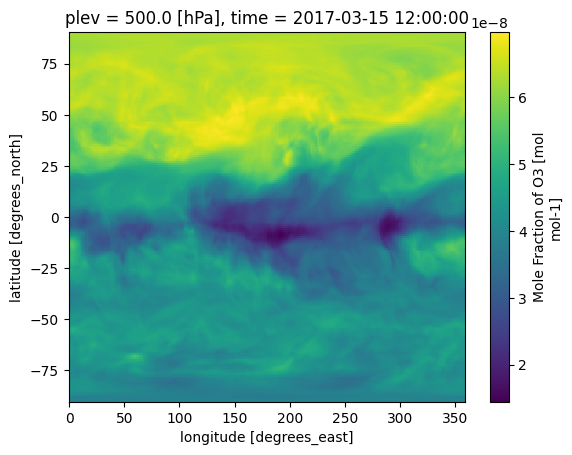

In [4]:
# by value:
ds.o3.sel(time='2017-03-15', plev=500).plot()

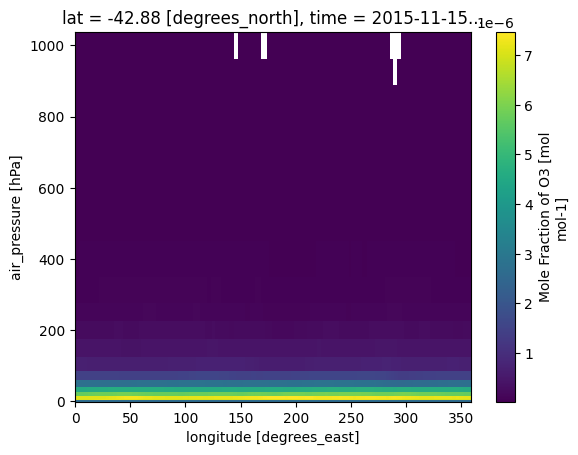

In [5]:
# by index:
ds.o3.isel(time=10, lat=50).plot()

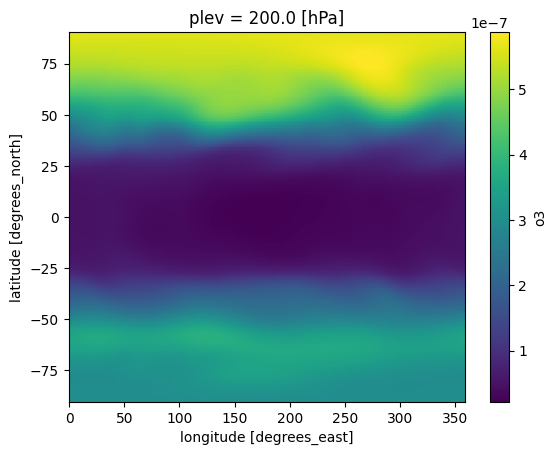

In [6]:
# take average of:
ds.o3.isel(plev=9).mean(dim='time').plot()

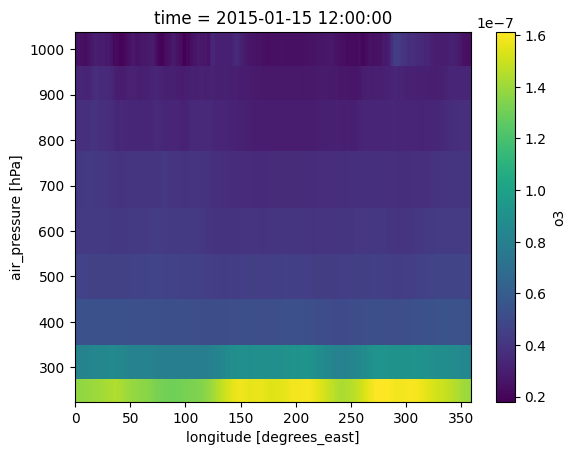

In [7]:
# slicing (selecting a range):
ds.o3.mean(dim='lat').isel(time=0,plev=slice(0,9)).plot()

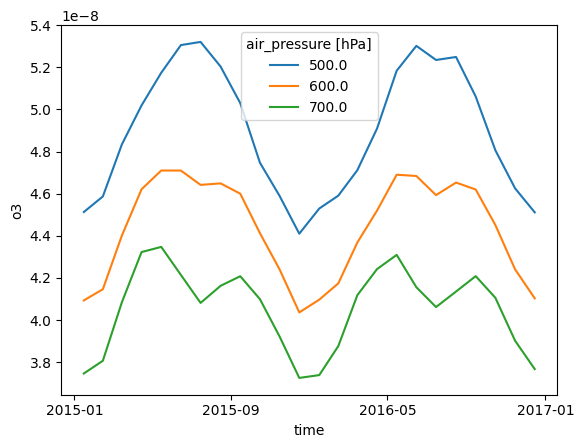

In [8]:
# selecting multiple values
ds.o3.mean(dim='lon').mean(dim='lat').isel(time=slice(0,24), plev=[5,4,3]).plot(hue='plev')

In [9]:
# getting attributes:
ds.o3.time.attrs

{'axis': 'T',
 'bounds': 'time_bnds',
 'standard_name': 'time',
 'title': 'time',
 'type': 'double'}

In [10]:
# converting to string:
print(str(ds.time[6].values))
print(f'{ds.plev[3].values} hPa')

2015-07-15 12:00:00
700.0 hPa


# Annotation and Customisation

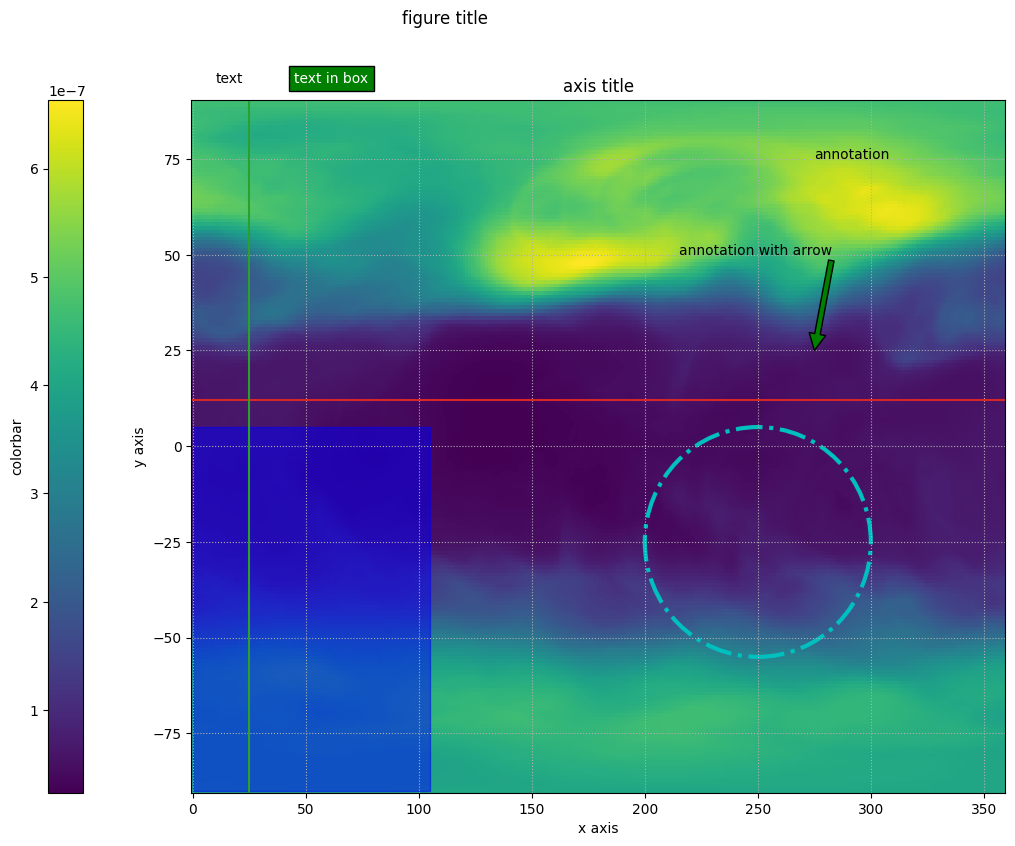

In [22]:
fig = plt.figure(figsize=(14,9))
ax = plt.axes()
graph = ds.o3.isel(time=0).sel(plev=200).plot(ax=ax, add_colorbar=False)


colorbar = fig.colorbar(graph, ax=ax, location='left')

# adding text: (coordinates are based on grid coords)
fig.suptitle('figure title')
ax.set(title='axis title', xlabel='x axis', ylabel='y axis')
plt.text(x=10,y=95, s='text')
plt.text(x=45, y=95, s='text in box', color='w', bbox=dict(fc='g'))
ax.annotate(xy=(275,75), text='annotation')
ax.annotate(xy=(275,25), xytext=(215,50), text='annotation with arrow',arrowprops=dict(fc='g'))
colorbar.set_label("colorbar")
# for all text/titles, can change colour, font, style, size and more

#lines:
ax.axhline(y=12, c='tab:red') #horizontal line
ax.axvline(x=25, c='tab:green') #vertical line
ax.grid(True, ls=':')

#other:
rectangle = plt.Rectangle(xy=(0,-90), width=105, height=95, alpha=0.5, color='b')
circle = mpl.patches.Ellipse(xy=(250, -25), width=100, height=60, ec='c', fc='none', ls='-.', lw=3)
ax.add_patch(rectangle)
ax.add_patch(circle)
rectangle.set_url('https://www.google.com/') # --> can be a web link or file address in same folder/directory

# fig.savefig('annotate.svg') #links in images only work in svg format

# Plots

## Basic

CPU times: total: 4.47 s
Wall time: 5.1 s


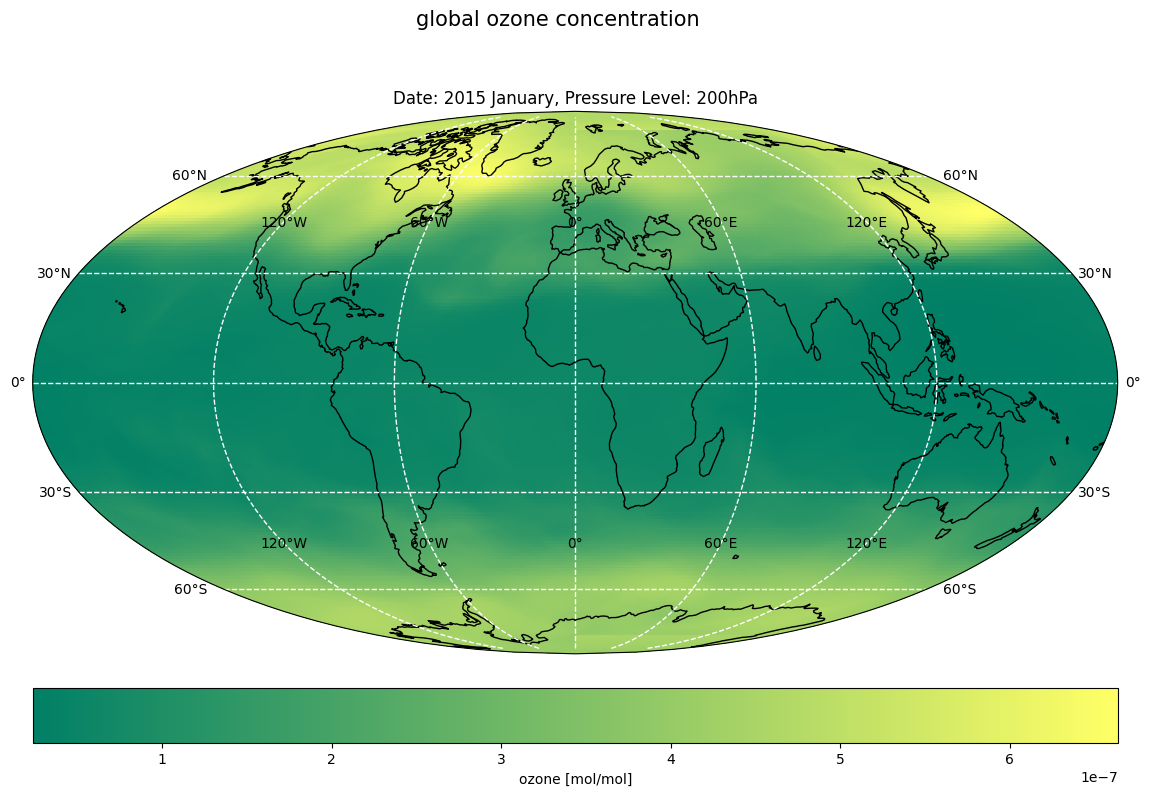

In [12]:
%%time
# location based scalar data -- colour plot

time = 0
pressure = 200
data = ds.o3.isel(time=time).sel(plev=pressure)

## Plotting
fig = plt.figure(figsize=(14,9))
ax = plt.axes(projection=ccrs.Mollweide())

# # with normal colours
graph = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='summer', add_colorbar=False)

## details
ax.gridlines(color='w', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)
colorbar = fig.colorbar(graph, ax=ax, location='bottom', pad=0.05)

## labels/words
colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(time), pressure))

# save figure
fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

CPU times: total: 203 ms
Wall time: 242 ms


Text(0.5, 1.0, 'Date: 2015 January, Pressure Level: 200hPa')

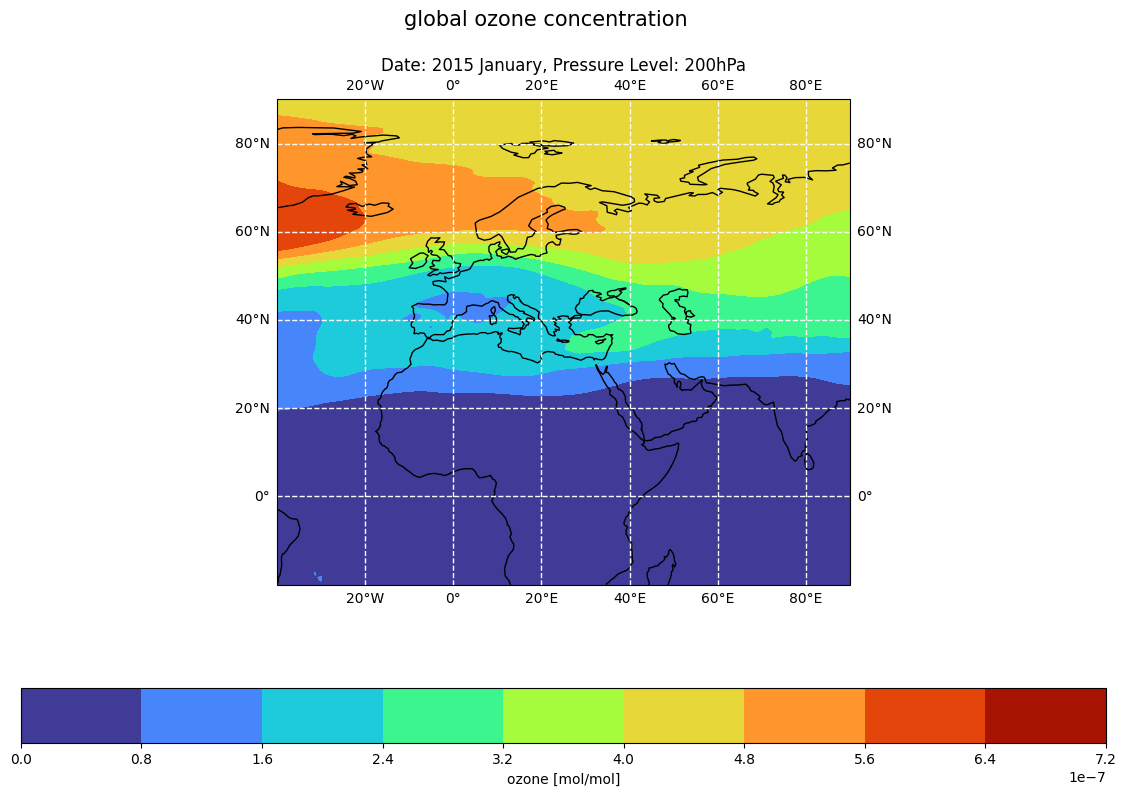

In [13]:
%%time
# location based scalar data -- contour plot
time = 0
pressure = 200
data = ds.o3.isel(time=time).sel(plev=pressure)
cmap = 'turbo'

## Plotting
fig = plt.figure(figsize=(14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# # contour lines no fill
# data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
# graph = ax.contour(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap)

# Filled contour lines
data, lons = cutil.add_cyclic_point(data, coord=ds.lon) #else would be a white line in middle
graph = ax.contourf(lons, ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap)

## details
ax.set_extent([-40,90, -20, 95], crs=ccrs.PlateCarree()) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='w', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)
colorbar = fig.colorbar(graph, ax=ax, location='bottom')

## labels/words
colorbar.set_label(label='ozone [mol/mol]', size=10)
fig.suptitle(t='global ozone concentration', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(time), pressure))

# save figure
# fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\ozone_conc.png')

CPU times: total: 46.9 ms
Wall time: 44.9 ms


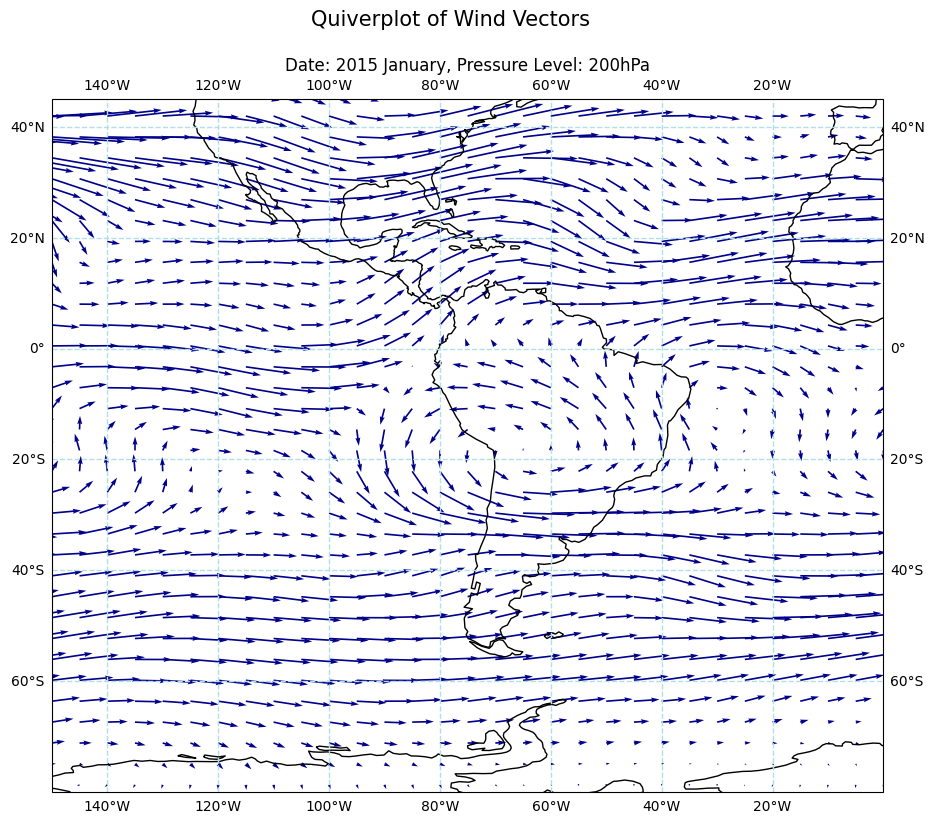

In [14]:
%%time
# location based vector data--> option 1: Quivers

# select and prepare data
time = 0
pressure = 200

u = ds.ua.isel(time=time).sel(plev=pressure)[::4, ::4]
v = ds.va.isel(time=time).sel(plev=pressure)[::4, ::4]
windspeed = (u**2 + v**2)**0.5
cmap = 'turbo'

## Plotting
fig = plt.figure(figsize=(14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

## details
ax.set_extent([-150,0, -80, 45], crs=ccrs.PlateCarree()) #[minlon, maxlon, minlat, maxlat]
ax.gridlines(color='powderblue', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)

## labels/words
colorbar.set_label(label='windspeed (m/s)', size=10)
fig.suptitle(t='Quiverplot of Wind Vectors', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(time), pressure))



# # plain coloured arrows
qv = ax.quiver(u.lon, u.lat, u, v, color='darkblue', scale=600, width=0.002, transform=ccrs.PlateCarree())

# # arrows coloured by strength
# qv = ax.quiver(u.lon, u.lat, u, v, windspeed, cmap=cmap, scale=600, width=0.002, transform=ccrs.PlateCarree())
# colorbar = fig.colorbar(qv, ax=ax, location='bottom')

# # but could also color this by a secondary variable...
# secondvar = ds.o3.isel(time=time).sel(plev=pressure)[::4, ::4]
# qv = ax.quiver(u.lon, u.lat, u, v, secondvar, cmap=cmap, scale=600, width=0.002, transform=ccrs.PlateCarree())
# colorbar = fig.colorbar(qv, ax=ax, location='bottom')



# save figure
# fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\vector_quiverplot.png')

CPU times: total: 3min 1s
Wall time: 18.2 s


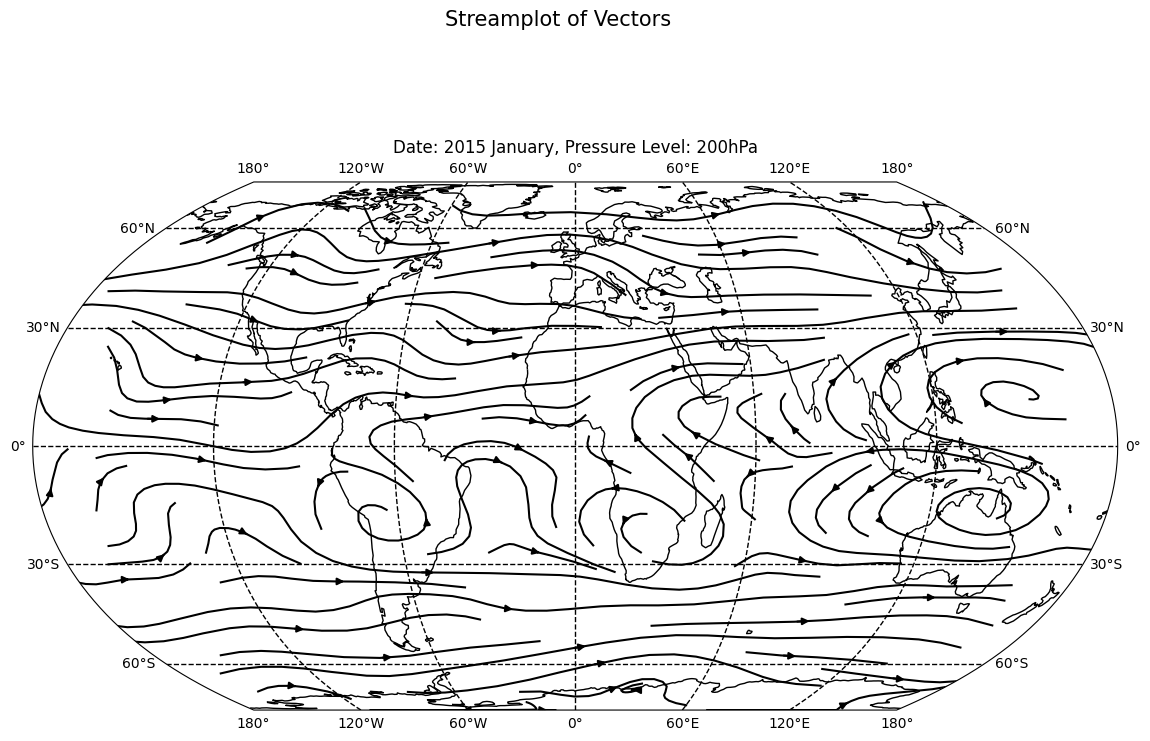

In [15]:
%%time
# location based vector data--> option 2: Streamplot

# select and prepare data
u = ds.ua.isel(time=0).sel(plev=200)[::4, ::4]
v = ds.va.isel(time=0).sel(plev=200)[::4, ::4]
windspeed = (u**2 + v**2)**0.5
linewidth = 4* (windspeed.values / windspeed.values.max())
cmap = 'summer'
proj = ccrs.EqualEarth()
trans = ccrs.PlateCarree()

## Plotting
fig = plt.figure(figsize=(14,9))
ax = plt.axes(projection=proj)

## details
ax.gridlines(color='k', linestyle='--', linewidth=1, draw_labels=True)
ax.coastlines(color='k', linewidth=1)

## labels/words
colorbar.set_label(label='windspeed (m/s)', size=10)
fig.suptitle(t='Streamplot of Vectors', size=15)
ax.set_title(label='Date: %s, Pressure Level: %.fhPa' %(timefmt(0), 200))



# options for streamplot: 

# Plain:
strm = ax.streamplot(u.lon, u.lat, u, v, transform=trans, color='k')

# # Windspeed= Background Colour
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=trans, color='w')
# bg = windspeed.plot(ax=ax, cmap=cmap, transform=trans, add_colorbar=False)
# colorbar = fig.colorbar(bg, ax=ax, location='bottom')

# # Windspeed= Streamline Colour
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=trans, color=windspeed.values, cmap=cmap)
# colorbar = fig.colorbar(strm.lines, ax=ax, location='bottom')

# # Windspeed= Line Width
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=trans, color='k', linewidth=linewidth)

# # Continuous Lines
# strm = ax.streamplot(u.lon, u.lat, u, v, transform=trans, color='k', broken_streamlines=False, density=0.75)



# save figure
# fig.savefig('H:\\Summer24-25\\Jupyter\\Plots_download\\vector_streamplot.png')

CPU times: total: 24 s
Wall time: 24.7 s


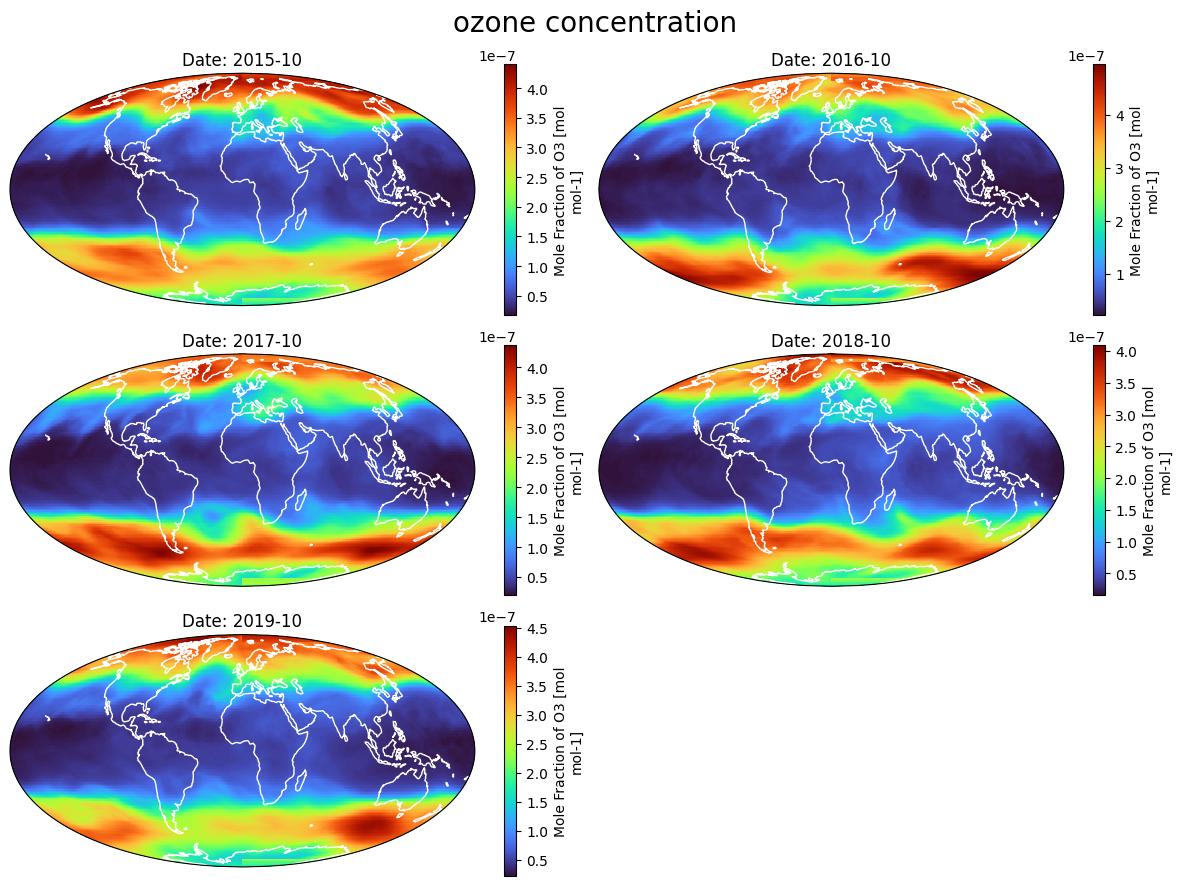

In [16]:
%%time
# autofit grid of graphs to fit list of times
times = ['2015-10', '2016-10', '2017-10', '2018-10', '2019-10'] # values- use with ds.o3.sel
# times = [9, 21, 33, 45] # indices- use with ds.o3.isel

ds_constants = ds.o3.sel(plev=200) # setting pressure level to 200hPa
cmap = 'turbo'



row,col = math.ceil(len(times)**0.5), round(len(times)**0.5)
fig, axs = plt.subplots(row,col, figsize=(col*6, row*3), layout='tight', subplot_kw=
                        {'projection': ccrs.Mollweide()})

fig.suptitle('ozone concentration', size=20)
i = 0
for ax in axs.flat:
    if i < len(times):
        # by values: 
        ds_constants.sel(time=times[i]).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
        ax.set_title('Date: %s' %times[i])

        # # by indices:
        # ds_constants.isel(time=times[i]).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
        # ax.set_title('Date: %s' %timefmt(times[i]))

        
        ax.coastlines(color='w')
        i += 1
    else:
        ax.remove()

fig.savefig('vary_subplots_example.png')

## Animated

CPU times: total: 18.4 s
Wall time: 21.2 s


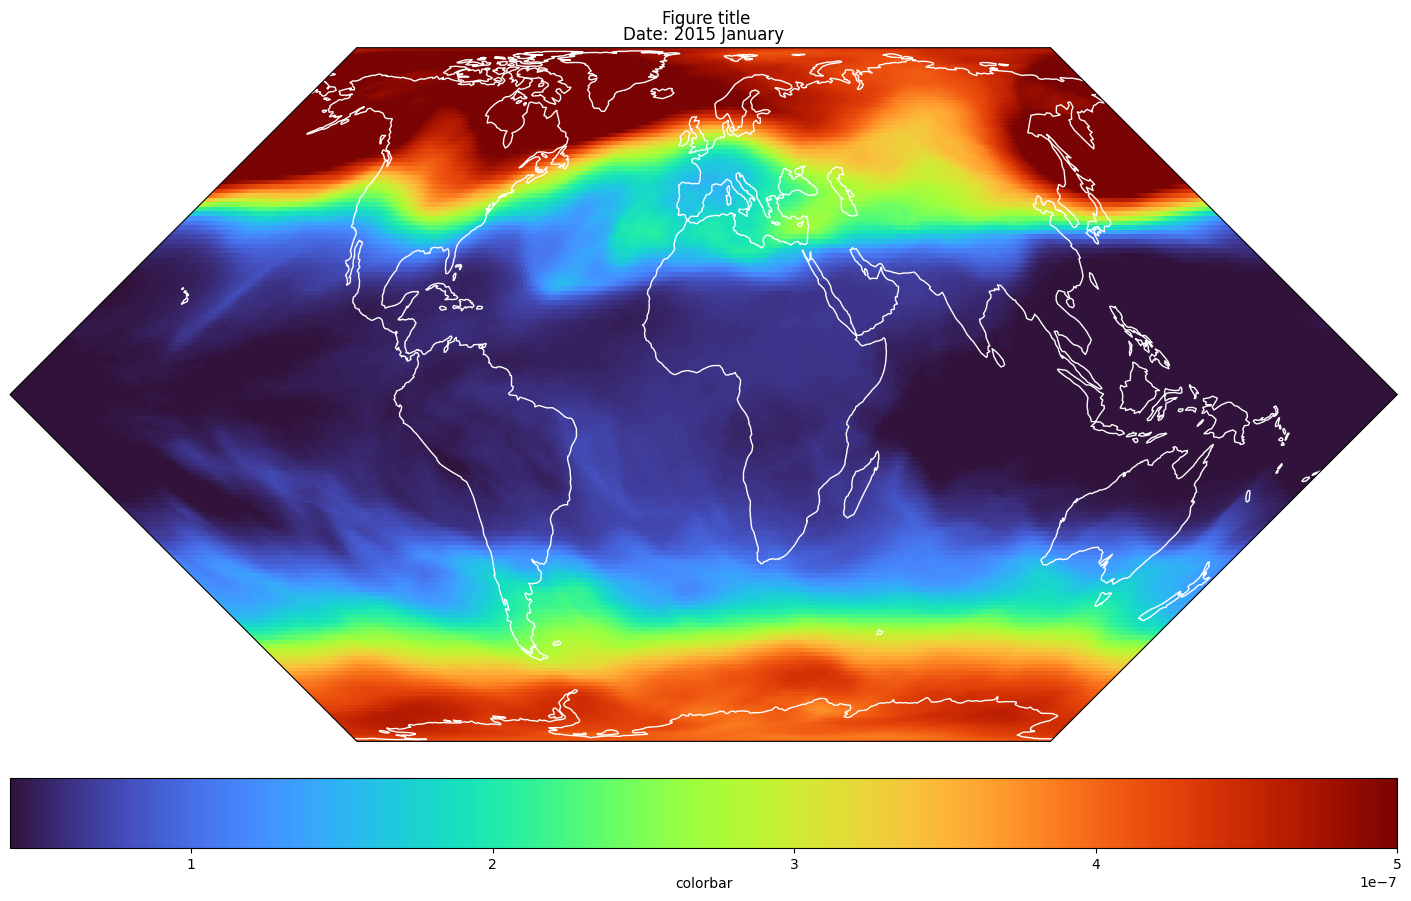

In [17]:
%%time
# animated plots --> animated by timestep -> dataset must have time coordinates

ds_constants = ds.o3.sel(plev=200) # fixing pressure level at 200hPa
num_frames = 25
cmap = 'turbo'
cnorm = mpl.colors.Normalize(vmin=4*10**-8, vmax=5*10**-7)

fig, ax = plt.subplots(figsize=(14,9), layout='compressed', subplot_kw=
                        {'projection': ccrs.EckertII()})

fig.suptitle('Figure title')

graph = ds_constants.isel(time=0).plot.pcolormesh(ax=ax, cmap=cmap, norm=cnorm, transform=ccrs.PlateCarree(), add_colorbar=False)
colorbar = fig.colorbar(graph, ax=ax, location='bottom', label='colorbar')
ax.coastlines(color='w')

def animate(num): # function to update each frame
    graph.set_array(ds_constants.isel(time=num))
    ax.set_title('Date: %s' %timefmt(num))

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200)

anim.save('normnorm.gif', writer='pillow')
